-----
# cartoGRAPHs - FEATURE TUNING

A Notebook to produce 2D and 3D network layouts from any Graph,
including interactive visualization (html files) and export functions 
to import into the VRNetzer analytics platform by Pirch et al.

Please note: 
Large graphs (e.g. 20k nodes / 300k links) can take ~15min using TSNE-based layouts and ~5min using UMAP-based layouts

-----

In [1]:
from cartoGRAPHs import * 

from func_load_data import *
from func_visual_properties import * 
from func_calculations import * 
from func_embed_plot import * 
from func_exportVR import * 

_____
# 1 | DEFINE NETWORK
_____

In [2]:
G = nx.cycle_graph(9)

l_features = ['nodeID:'+str(i) for i in list(G.nodes())]

In [3]:
path = 'output_plots/benchmark/'

In [4]:
edge_opacity = 1
edge_width = 5
node_size = 45
node_width = 3

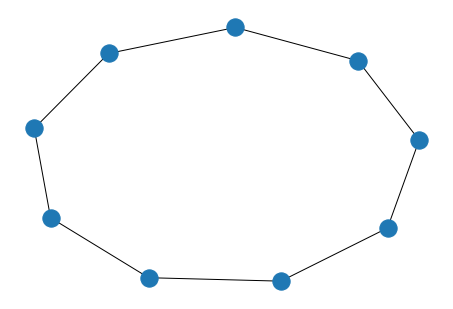

In [5]:
nx.draw(G)

### FUNCTIONAL

In [6]:
scale = 0

In [7]:
rows = len(list(G.nodes()))
feat_one = [(1) if i%3 else (scale) for i in range(rows)]
feat_two = [(1) if i%2 or feat_one[i]==scale in feat_one else (scale) for i in range(rows)]
feat_three = [(scale) if feat_one[i]==1 and feat_two[i]==1 else 1 for i in range(rows)]
feat_matrix = np.vstack((feat_one,feat_two,feat_three))

In [8]:
# colors based on features 

col_one = 'orange' #'darkblue'
col_two = 'cornflowerblue'
col_three = 'skyblue'

colors_assigned = dict(zip(list(G.nodes()), [col_one,col_three,col_two,col_one,col_two,col_three,col_one,col_three,col_two]))
color_list = list(colors_assigned.values())

In [9]:
DF_functional = pd.DataFrame(feat_matrix)
DF_functional.index = [100,101,102]

In [10]:
DF_functional

,0,1,2,3,4,5,6,7,8
100,0,1,1,0,1,1,0,1,1
101,1,1,0,1,0,1,1,1,0
102,1,0,1,1,1,0,1,0,1


### STRUCTURAL 

In [11]:
r=0.9
alpha=1.0

A = nx.adjacency_matrix(G)
FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
DF_structural = pd.DataFrame(FM_m_array).T
DF_structural.index = list(G.nodes())
DF_structural.columns = list(G.nodes()) 

In [12]:
DF_structural

,0,1,2,3,4,5,6,7,8
0,0.904534,0.045340,0.002273,0.000114,0.000006,0.000006,0.000114,0.002273,0.045340
1,0.045340,0.904534,0.045340,0.002273,0.000114,0.000006,0.000006,0.000114,0.002273
2,0.002273,0.045340,0.904534,0.045340,0.002273,0.000114,0.000006,0.000006,0.000114
3,0.000114,0.002273,0.045340,0.904534,0.045340,0.002273,0.000114,0.000006,0.000006
4,0.000006,0.000114,0.002273,0.045340,0.904534,0.045340,0.002273,0.000114,0.000006
5,0.000006,0.000006,0.000114,0.002273,0.045340,0.904534,0.045340,0.002273,0.000114
6,0.000114,0.000006,0.000006,0.000114,0.002273,0.045340,0.904534,0.045340,0.002273
7,0.002273,0.000114,0.000006,0.000006,0.000114,0.002273,0.045340,0.904534,0.045340
8,0.045340,0.002273,0.000114,0.000006,0.000006,0.000114,0.002273,0.045340,0.904534


In [13]:
# normalize DF structural

cols = DF_structural.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(DF_structural)
DF_structural_normalized = pd.DataFrame(np_scaled, columns = cols)
DF_structural_norm = DF_structural_normalized.round(6)

### BOTH INTO ONE MATRIX (structural + functional)

In [113]:
scalar = 0.90
DF_functional_scal = DF_functional*scalar
DF_functional_scal

,0,1,2,3,4,5,6,7,8
100,0.0,0.9,0.9,0.0,0.9,0.9,0.0,0.9,0.9
101,0.9,0.9,0.0,0.9,0.0,0.9,0.9,0.9,0.0
102,0.9,0.0,0.9,0.9,0.9,0.0,0.9,0.0,0.9


In [114]:
DF_merge = pd.concat([DF_structural_norm, #.T, 
                      DF_functional_scal]).T

In [115]:
n_neighbors = 3 #int(len(G.nodes()))#*0.75)
spread = 1
min_dist = 0.0 #0
#metric='euclidean'
metric='cosine'

umap2D_merge = embed_umap_2D(DF_merge , n_neighbors, spread, min_dist, metric)
posG_merge = get_posG_2D_norm(G, DF_merge , umap2D_merge)

In [116]:
trace_nodes = get_trace_nodes_2D(posG_merge, list(G.nodes()), color_list, size=node_size, linewidth=node_width)
trace_edges = get_trace_edges_2D(G, posG_merge, color='dimgrey', opac=edge_opacity ,linewidth=edge_width)

data = [trace_edges,trace_nodes]
fname = 'FeatureTuning_merge_FuncScalar'+str(scalar)

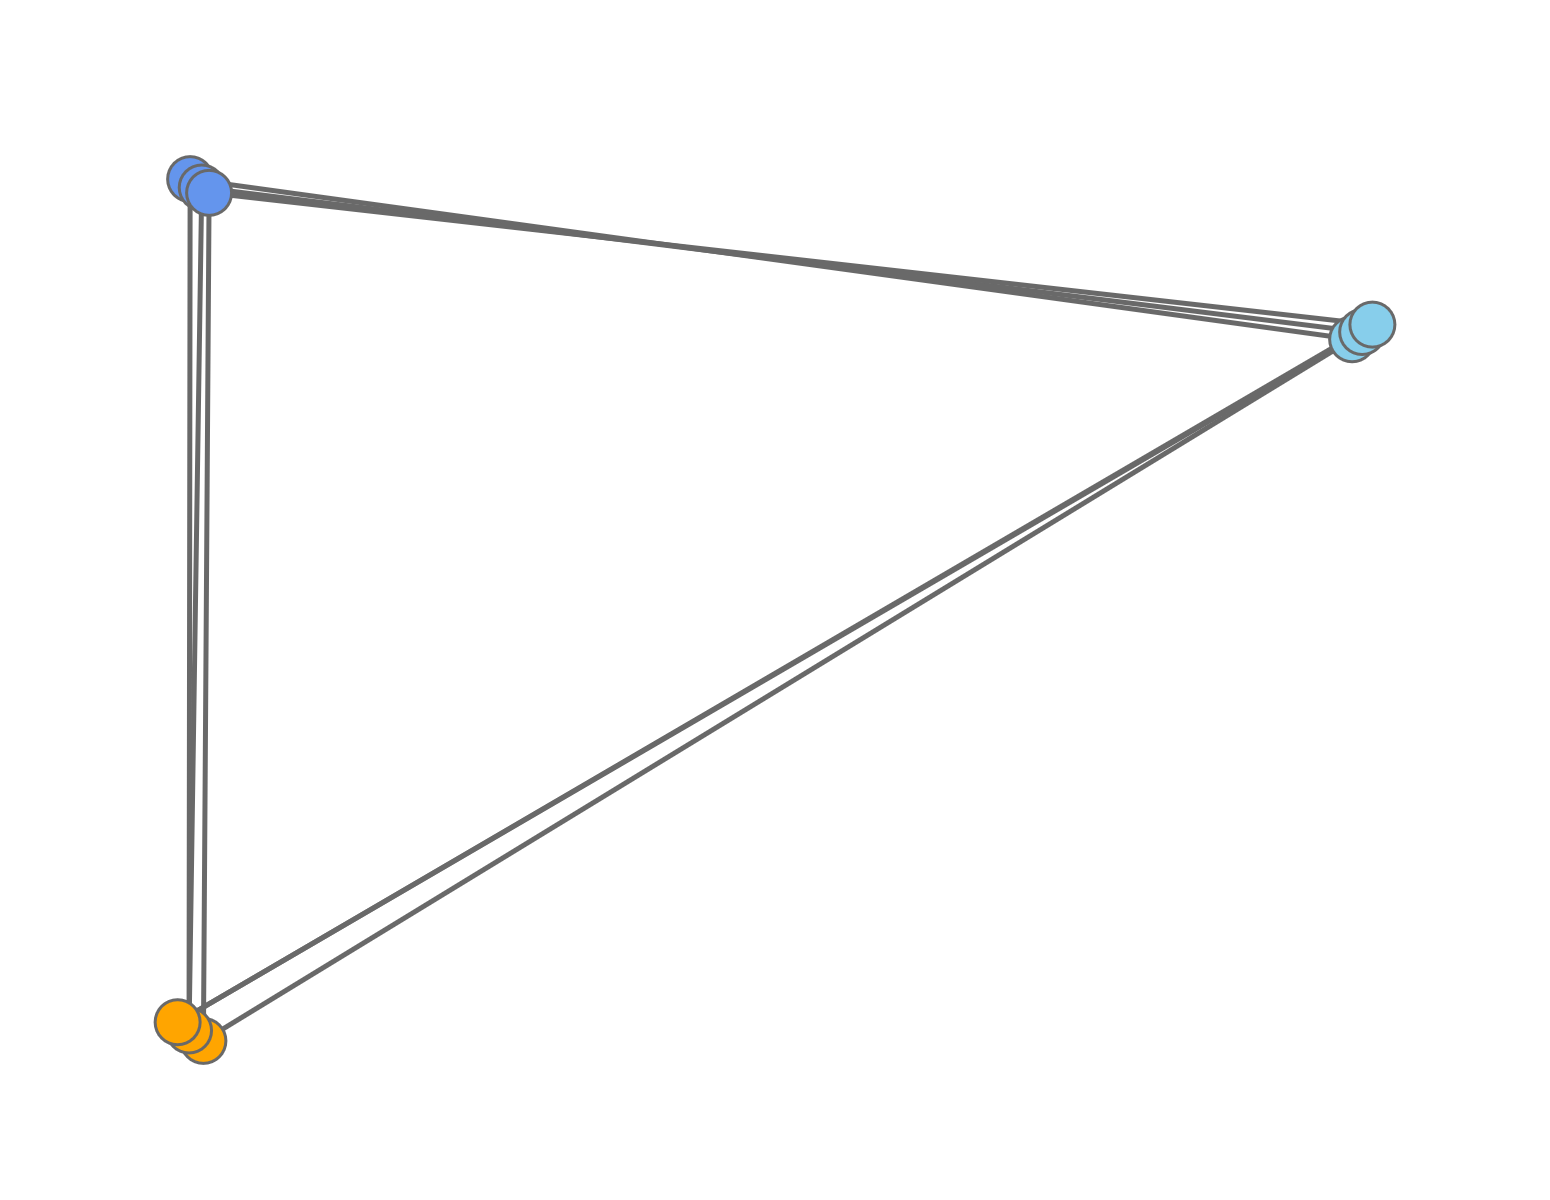

In [117]:
fig = pgo.Figure()
    
for i in data:
    fig.add_trace(i)
        
fig.update_layout(template= 'plotly_white', 
                      showlegend=False, width=1200, height=1200,
                          scene=dict(
                              xaxis_title='',
                              yaxis_title='',
                              xaxis=dict(nticks=0,tickfont=dict(
                                    color='white')),
                              yaxis=dict(nticks=0,tickfont=dict(
                                    color='white')),
                        ))    
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)

fig.write_image(path+fname+'_'+'nn'+str(n_neighbors)+'_spr'+str(spread)+'_min'+str(min_dist)+'_'+metric+'.pdf')
fig.show()

In [115]:
# IDEA 1: 
# merge features for rows + columns to be symmetric

# IDEA 2: 
# merge matrix similarly to RWR mix tests